# Statistics of EDR targets with multiple spectra

May 2023

*Angela Berti (U.Utah), Ragadeepika Pucha (U.Arizona), Stephanie Juneau (NOIRLab), Anthony Kremin (Berkeley Lab), Jaime E. Forero-Romero (Uniandes) and DESI Data Team*

This notebook has been tested with the DESI 23.1 kernel.

### Table of Contents
* [Overview](#overview)
* [Imports](#imports)
* [Accessing the data](#data)
* [Catalog statistics by survey](#stats_survey)
  * [Unique targets in each survey](#counts_survey_total)
* [Primary spectra](#primary)
* [Catalog statistics by target type](#stats_target)
  * [DESI target masks](#masks_desi)
  * [Spectra by target type](#counts_target)
* [Redshift distributions by target type and survey](#redshift_dist)
* [Target counts by target type and survey](#counts_target_survey)
* [Targets with multiple spectra](#multispec)
  * [Multiple SPECTYPE classifications](#spectype_diff)
  * [Bright versus dark time spectra of the same target](#bright_dark)

<a class="anchor" id="overview"></a>
## Overview

This notebook demonstrates how to flag a unique set of the primary (i.e., best) spectrum for an object in the EDR catalog, and apply some basic quality cuts. This notebook also provides examples of how break down the data in the combined catalog by target type (BGS, LRG, etc.), survey (SV1, SV2, etc.), and the number of spectra per target. Finally, it covers how to extract and plot different spectra of the same target.

<a class="anchor" id="imports"></a>
## Imports

In [5]:
import os
import numpy as np

import fitsio

from astropy.io import fits
from astropy.table import Table, vstack, join
from astropy.convolution import convolve, Gaussian1DKernel

import matplotlib
import matplotlib.pyplot as plt

#-- input/output functions related to DESI spectra
import desispec.io

plt.style.use("../../mpl/desi.mplstyle")


<a class="anchor" id="data"></a>
## Accessing the data

The DESI Early Data Release (EDR) consists some of the commissioning data, as well as the whole of the survey validation (SV) data. This includes SV1, SV2, and SV3 (1% survey). 
Information about the SV data can be found [here](https://data.desi.lbl.gov/doc/). 

For the EDR data, the spectra are divided by the `SURVEY` (sv1/sv2/sv3) they were observed in. The observing conditions (dark or bright), called as `PROGRAM` in the DESI terminology, is used to categorize the spectra further. 

In [6]:
# Release directory path

specprod = "fuji"    # Internal name for the EDR
specprod_dir = "/global/cfs/cdirs/desi/public/edr/spectro/redux/fuji/"
print(specprod_dir)


/global/cfs/cdirs/desi/public/edr/spectro/redux/fuji/


In [7]:
fujidata = Table( fitsio.read(os.path.join(specprod_dir, "zcatalog", "zall-pix-{}.fits".format(specprod))) )

<a class="anchor" id="stats_survey"></a>

## Statistics of the combined catalog by survey

<a class="anchor" id="masks_survey"></a>

### Create masks to select each survey

In [8]:
#-- SV1/2/3
is_sv1 = (fujidata["SURVEY"].astype(str).data == "sv1")
is_sv2 = (fujidata["SURVEY"].astype(str).data == "sv2")
is_sv3 = (fujidata["SURVEY"].astype(str).data == "sv3")

#-- all SV data
is_sv = (is_sv1 | is_sv2 | is_sv3)

#-- commissioning data
is_cmx = (fujidata["SURVEY"].astype(str).data == "cmx")

#-- special tiles
is_special = (fujidata["SURVEY"].astype(str).data == "special")

<a class="anchor" id="counts_survey_total"></a>

### Identify the total number of unique targets observed in each survey, as well as in the combined catalog

Uncomment specific lines to print numbers for additional surveys.

In [9]:
#-- all unique targets in SV
targids_sv = np.unique(fujidata["TARGETID"][is_sv])

print("Unique targets in SV:     {0:8}".format( len(targids_sv) ))

print("\nTotal unique targets in combined catalog: {}\n".format( len(np.unique(fujidata["TARGETID"])) ))

print("Unique targets in SV1:    {0:8}".format( len(np.unique(fujidata["TARGETID"][is_sv1])) ))
print("Unique targets in SV2:    {0:8}".format( len(np.unique(fujidata["TARGETID"][is_sv2])) ))
print("Unique targets in SV3:    {0:8}".format( len(np.unique(fujidata["TARGETID"][is_sv3])) ))

print("\nUnique targets in CMX:    {0:8}".format( len(np.unique(fujidata["TARGETID"][is_cmx])) ))

print("\nUnique targets in Special:{0:8}".format( len(np.unique(fujidata["TARGETID"][is_special])) ))


Unique targets in SV:      2704365

Total unique targets in combined catalog: 2757937

Unique targets in SV1:      860284
Unique targets in SV2:      167961
Unique targets in SV3:     1701805

Unique targets in CMX:        5000

Unique targets in Special:   50136


<a class="anchor" id="primary"></a>

## Primary spectra

The catalog contains columns that flag the set of primary spectra within just SV data (`SV_PRIMARY`) and the across entire catalog (`ZCAT_PRIMARY`). Note that the set of primary spectra identified within just SV data (`SV_PRIMARY` flag) is *not* the same as identifying primary spectra across the entire combined catalog and *then* selecting by survey, i.e.,

$$
\begin{align}
\texttt{fujidata}["\!\texttt{ZCAT}\_\texttt{PRIMARY}\!"][\ \texttt{is}\_\texttt{sv}\ ] &\neq \texttt{fujidata}["\!\texttt{SV}\_\texttt{PRIMARY}\!"] 
\end{align}
$$

<a class="anchor" id="counts_survey_unique"></a>
### How many primary spectra are in SV, the combined catalog, and other surveys?
Uncomment specific lines to print numbers for other surveys.

In [10]:
print("Primary spectra in...\n")
print("  SV:              {0:8}".format( np.count_nonzero(is_sv & fujidata["SV_PRIMARY"])))
print("  combined catalog:{0:8}\n".format( np.count_nonzero(fujidata["ZCAT_PRIMARY"])))

print("  SV1:    {0:8}".format( np.count_nonzero(is_sv1 & fujidata["SV_PRIMARY"]) ))
print("  SV2:    {0:8}".format( np.count_nonzero(is_sv2 & fujidata["SV_PRIMARY"]) ))
print("  SV3:    {0:8}\n".format( np.count_nonzero(is_sv3 & fujidata["SV_PRIMARY"]) ))

print("  CMX:    {0:8}\n".format( np.count_nonzero(is_cmx & fujidata["ZCAT_PRIMARY"]) ))

print("  Special:{0:8}".format( np.count_nonzero(is_special & fujidata["ZCAT_PRIMARY"]) ))


Primary spectra in...

  SV:               2704365
  combined catalog: 2757937

  SV1:      853165
  SV2:      166865
  SV3:     1684335

  CMX:        5000

  Special:   48611



<a class="anchor" id="stats_target"></a>
## Statistics of the combined catalog by target type

<a class="anchor" id="masks_desi"></a>
### DESI target masks

Targeting bits are encoded in `desi_mask`, which can be imported from `desitarget.targetmask` or from any of the SV libraries (e.g., from `desitarget.sv1.sv1_targetmask`, etc.). While not universally true, for the purposes of this notebook it doesn"t matter which `desi_mask` is used; any of the four import options below will give the same results.


In [11]:
from desitarget.targetmask import desi_mask, bgs_mask, scnd_mask
# from desitarget.sv1.sv1_targetmask import desi_mask, bgs_mask, scnd_mask  # SV1
# from desitarget.sv2.sv2_targetmask import desi_mask, bgs_mask, scnd_mask  # SV2
# from desitarget.sv3.sv3_targetmask import desi_mask, bgs_mask, scnd_mask  # SV3


In [12]:
#-- select the target mask for each type of target (BGS, LRG, ELG, QSO, etc.)

bgs_tgtmask  = desi_mask["BGS_ANY"]
lrg_tgtmask  = desi_mask["LRG"]
elg_tgtmask  = desi_mask["ELG"]
qso_tgtmask  = desi_mask["QSO"]
mws_tgtmask  = desi_mask["MWS_ANY"]
scnd_tgtmask = desi_mask["SCND_ANY"]


<a class="anchor" id="masks_target"></a>

### Define masks to select all targets of each type from the combined catalog

Information about DESI target selection is stored in the `DESI_TARGET` column. Similarly, the `SV1_DESI_TARGET`, `SV2_DESI_TARGET`, and `SV3_DESI_TARGET` columns indicate which objects were targeted specifically during SV. The masks below select *all* targets of a given type.


In [13]:
desi_target = fujidata["DESI_TARGET"]

#-- all BGS targets
is_bgs = (desi_target & bgs_tgtmask != 0) | (fujidata["SV1_DESI_TARGET"] & bgs_tgtmask != 0) | \
         (fujidata["SV2_DESI_TARGET"] & bgs_tgtmask != 0) | (fujidata["SV3_DESI_TARGET"] & bgs_tgtmask != 0)

#-- all LRG targets
is_lrg = (desi_target & lrg_tgtmask != 0) | (fujidata["SV1_DESI_TARGET"] & lrg_tgtmask != 0) | \
         (fujidata["SV2_DESI_TARGET"] & lrg_tgtmask != 0) | (fujidata["SV3_DESI_TARGET"] & lrg_tgtmask != 0)

#-- all ELG targets
is_elg = (desi_target & elg_tgtmask != 0) | (fujidata["SV1_DESI_TARGET"] & elg_tgtmask != 0) | \
         (fujidata["SV2_DESI_TARGET"] & elg_tgtmask != 0) | (fujidata["SV3_DESI_TARGET"] & elg_tgtmask != 0)

#-- all QSO targets
is_qso = (desi_target & qso_tgtmask != 0) | (fujidata["SV1_DESI_TARGET"] & qso_tgtmask != 0) | \
         (fujidata["SV2_DESI_TARGET"] & qso_tgtmask != 0) | (fujidata["SV3_DESI_TARGET"] & qso_tgtmask != 0)

#-- all Milky Way targets
is_mws = (desi_target & mws_tgtmask != 0) | (fujidata["SV1_DESI_TARGET"] & mws_tgtmask != 0) | \
         (fujidata["SV2_DESI_TARGET"] & mws_tgtmask != 0) | (fujidata["SV3_DESI_TARGET"] & mws_tgtmask != 0)

#-- all secondary targets
is_scnd = (desi_target & scnd_tgtmask != 0) | (fujidata["SV1_DESI_TARGET"] & scnd_tgtmask != 0) | \
          (fujidata["SV2_DESI_TARGET"] & scnd_tgtmask != 0) | (fujidata["SV3_DESI_TARGET"] & scnd_tgtmask != 0)


<a class="anchor" id="counts_target"></a>
### Plot the total number of spectra of each target type


In [14]:
#-- total number of spectra by target type
n_bgs  = np.count_nonzero(is_bgs)
n_lrg  = np.count_nonzero(is_lrg)
n_elg  = np.count_nonzero(is_elg)
n_qso  = np.count_nonzero(is_qso)
n_mws  = np.count_nonzero(is_mws)
n_scnd = np.count_nonzero(is_scnd)

counts = [n_bgs, n_lrg, n_elg, n_qso, n_mws, n_scnd]

#-- number of primary spectra by target type
is_primary = fujidata["ZCAT_PRIMARY"]

n_bgs_prim  = np.count_nonzero(is_bgs & is_primary)
n_lrg_prim  = np.count_nonzero(is_lrg & is_primary)
n_elg_prim  = np.count_nonzero(is_elg & is_primary)
n_qso_prim  = np.count_nonzero(is_qso & is_primary)
n_mws_prim  = np.count_nonzero(is_mws & is_primary)
n_scnd_prim = np.count_nonzero(is_scnd & is_primary)

counts_prim = [n_bgs_prim, n_lrg_prim, n_elg_prim, n_qso_prim, n_mws_prim, n_scnd_prim]


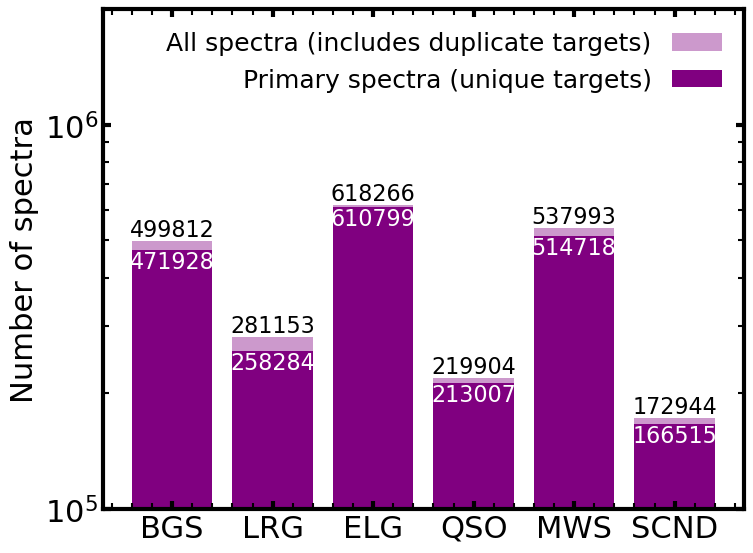

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

targets = ["BGS", "LRG", "ELG", "QSO", "MWS", "SCND"]

ax.bar(targets, counts, color="purple", alpha=0.4, label="All spectra (includes duplicate targets)")
ax.bar(targets, counts_prim, color="purple", alpha=1, label="Primary spectra (unique targets)")
ax.set_ylabel("Number of spectra")
ax.semilogy()
ax.set_ylim(1e5, 2e6)

for i in range(len(targets)):
    ax.text(targets[i], counts[i], counts[i], ha="center", va="bottom", fontsize=16)
    ax.text(targets[i], counts_prim[i], counts_prim[i], ha="center", va="top", fontsize=16, color="white")

plt.legend(fontsize=18, frameon=False, markerfirst=False)
plt.tight_layout()
plt.show()


<a class="anchor" id="redshift_dist"></a>

## Redshift distributions by target type and survey

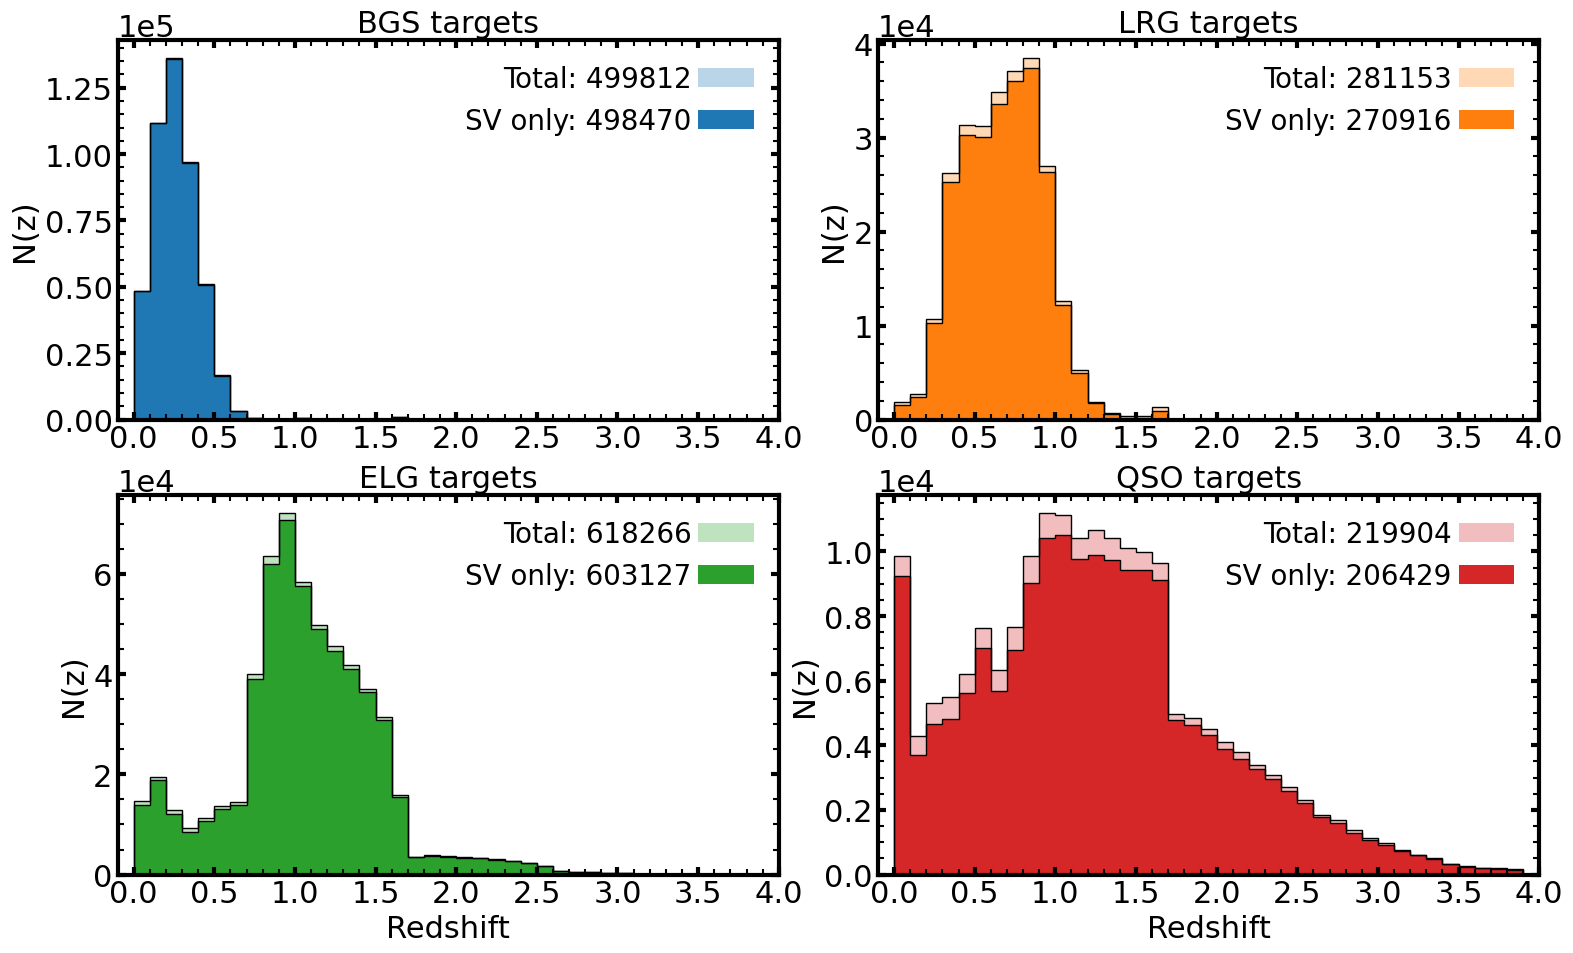

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(16,10))

bins = np.arange(0,4,0.1)

type_masks = (is_bgs, is_lrg, is_elg, is_qso)
colors     = ("C0","C1","C2","C3")

for ax,type_mask,name,color in zip(np.concatenate(axes), type_masks, targets[:-2], colors):
    kwargs = dict(color=color, bins=bins)
    
    ax.hist(fujidata["Z"][type_mask], **kwargs, alpha=0.3, label=f"Total: {len(fujidata[type_mask])}")
    ax.hist(fujidata["Z"][type_mask], bins=bins, histtype="step", color="black")
    
    mask = type_mask & is_sv
    ax.hist(fujidata["Z"][mask], **kwargs, label=f"SV only: {len(fujidata[mask])}")
    ax.hist(fujidata["Z"][mask], bins=bins, histtype="step", color="black")
    
    ax.legend(fontsize=20, markerfirst=False, handletextpad=0.25, frameon=False)
    ax.set_title(f"{name} targets", fontsize=22)

for ax in axes[-1]:
    ax.set_xlabel("Redshift")

for ax in np.concatenate(axes):
    ax.set_xlim(-0.1,4.0)
    ax.set_xticks(np.arange(0,4.1,0.5))
    ax.set_ylabel("N(z)")
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

plt.tight_layout()
plt.subplots_adjust(hspace=0.2, wspace=0.15)

### Target class versus Redrock spectral type

The above plot shows $N(z)$ for all *targets* of a given type, but [Redrock](https://github.com/desihub/redrock) will not necessarily classify all spectra as having the same spectral type as their original target class. For example, the following plot breaks down QSO targets by their Redrock spectral type (`GALAXY`, `QSO`, or `STAR`), contained in the `SPECTYPE` column.

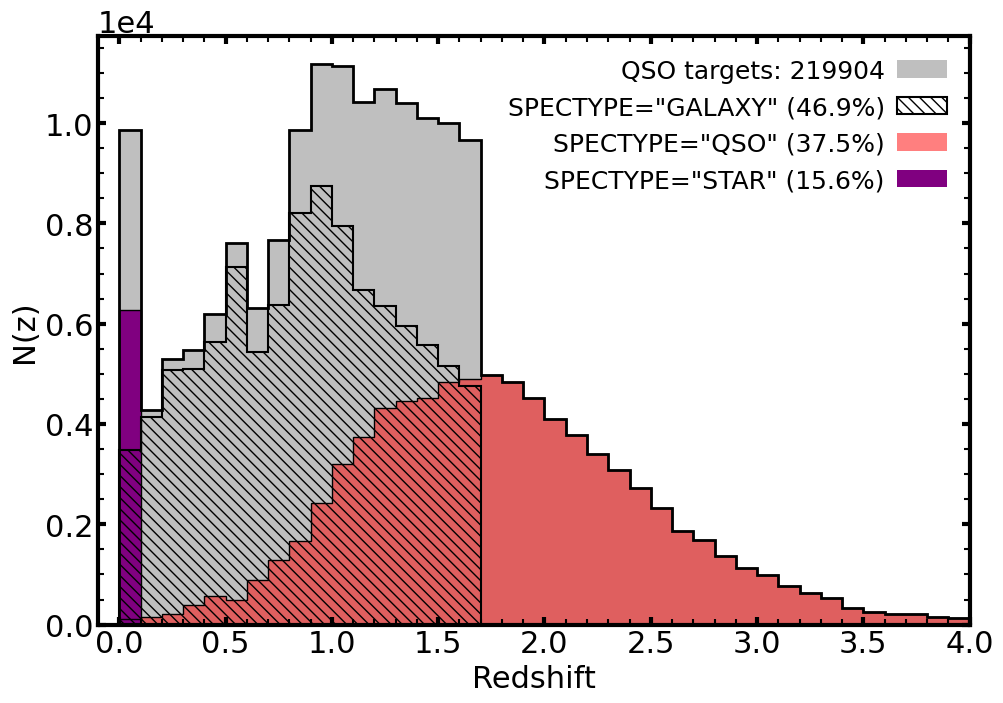

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10.5,7.5))

bins = np.arange(0,4.1,0.1)

#-- all QSO targets
ax.hist(fujidata["Z"][is_qso], bins=bins, color="gray", alpha=0.5, label=f"QSO targets: {n_qso}")

#-- QSO targets classified as galaxies
spec_gal = is_qso & (fujidata["SPECTYPE"]=="GALAXY")
ax.hist(fujidata["Z"][spec_gal], bins=bins, histtype="step", hatch="\\\\\\", color="k", lw=1.5,
        label=f"SPECTYPE=\"GALAXY\" ({100*len(fujidata[spec_gal])/n_qso:.1f}%)")

#-- QSO targets classified as quasars
spec_qso = is_qso & (fujidata["SPECTYPE"]=="QSO")
ax.hist(fujidata["Z"][spec_qso], bins=bins, color="red", alpha=0.5,
        label=f"SPECTYPE=\"QSO\" ({100*len(fujidata[spec_qso])/n_qso:.1f}%)")
ax.hist(fujidata["Z"][spec_qso], bins=bins, histtype="step", color="k", lw=1)

#-- QSO targets classified as stars
spec_star = is_qso & (fujidata["SPECTYPE"]=="STAR")
ax.hist(fujidata["Z"][spec_star], bins=bins, color="purple",
        label=f"SPECTYPE=\"STAR\" ({100*len(fujidata[spec_star])/n_qso:.1f}%)")
ax.hist(fujidata["Z"][spec_star], bins=bins, histtype="step", color="k", lw=1)

ax.hist(fujidata["Z"][is_qso], bins=bins, histtype="step", color="black", lw=2)

ax.legend(fontsize=18, markerfirst=False, handletextpad=0.5, frameon=False)

ax.set_xlabel("Redshift")
ax.set_xlim(-0.1,4.0)
ax.set_xticks(np.arange(0,4.1,0.5))
ax.set_ylabel("N(z)")
ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

plt.tight_layout()


Of the over 220k QSO targets in the catalog, only 38% are actually classified as quasars (red histogram) by Redrock. Nearly 46% are classified as galaxies (black hatched histogram), and the remaining 16% as stars (purple histogram at $z\sim0$). The abrupt drop in $N(z)$ at $z=1.7$ reflects the fact that Redrock is constrained to fit redshifts $z<1.7$ to spectra it classifies as galaxies.

<a class="anchor" id="counts_target_survey"></a>
## Target counts by target type and survey


In [15]:
#-- BGS
is_bgs_sv1 = (fujidata["SV1_DESI_TARGET"] & bgs_tgtmask != 0)
is_bgs_sv2 = (fujidata["SV2_DESI_TARGET"] & bgs_tgtmask != 0)
is_bgs_sv3 = (fujidata["SV3_DESI_TARGET"] & bgs_tgtmask != 0)
is_bgs_sv  = is_bgs_sv1 | is_bgs_sv2 | is_bgs_sv3 

#-- LRG
is_lrg_sv1 = (fujidata["SV1_DESI_TARGET"] & lrg_tgtmask != 0)
is_lrg_sv2 = (fujidata["SV2_DESI_TARGET"] & lrg_tgtmask != 0)
is_lrg_sv3 = (fujidata["SV3_DESI_TARGET"] & lrg_tgtmask != 0)
is_lrg_sv  = is_lrg_sv1 | is_lrg_sv2 | is_lrg_sv3

#-- ELG
is_elg_sv1 = (fujidata["SV1_DESI_TARGET"] & elg_tgtmask != 0)
is_elg_sv2 = (fujidata["SV2_DESI_TARGET"] & elg_tgtmask != 0)
is_elg_sv3 = (fujidata["SV3_DESI_TARGET"] & elg_tgtmask != 0)
is_elg_sv  = is_elg_sv1 | is_elg_sv2 | is_elg_sv3

#-- QSO
is_qso_sv1 = (fujidata["SV1_DESI_TARGET"] & qso_tgtmask != 0)
is_qso_sv2 = (fujidata["SV2_DESI_TARGET"] & qso_tgtmask != 0)
is_qso_sv3 = (fujidata["SV3_DESI_TARGET"] & qso_tgtmask != 0)
is_qso_sv  = is_qso_sv1 | is_qso_sv2 | is_qso_sv3

#-- Milky Way
is_mws_sv1 = (fujidata["SV1_DESI_TARGET"] & mws_tgtmask != 0)
is_mws_sv2 = (fujidata["SV2_DESI_TARGET"] & mws_tgtmask != 0)
is_mws_sv3 = (fujidata["SV3_DESI_TARGET"] & mws_tgtmask != 0)
is_mws_sv  = is_mws_sv1 | is_mws_sv2 | is_mws_sv3

#-- secondary
is_scnd_sv1 = (fujidata["SV1_DESI_TARGET"] & scnd_tgtmask != 0)
is_scnd_sv2 = (fujidata["SV2_DESI_TARGET"] & scnd_tgtmask != 0)
is_scnd_sv3 = (fujidata["SV3_DESI_TARGET"] & scnd_tgtmask != 0)
is_scnd_sv  = is_scnd_sv1 | is_scnd_sv2 | is_scnd_sv3


In [16]:
print("BGS    SV:{0:8}\n   Not SV:{1:8}\n".format(np.count_nonzero(is_bgs_sv), np.count_nonzero(is_bgs & ~is_bgs_sv) ))
print("LRG    SV:{0:8}\n   Not SV:{1:8}\n".format(np.count_nonzero(is_lrg_sv), np.count_nonzero(is_lrg & ~is_lrg_sv) ))

print("ELG    SV:{0:8}\n   Not SV:{1:8}\n".format(np.count_nonzero(is_elg_sv), np.count_nonzero(is_elg & ~is_elg_sv) ))
print("QSO    SV:{0:8}\n   Not SV:{1:8}\n".format(np.count_nonzero(is_qso_sv), np.count_nonzero(is_qso & ~is_qso_sv) ))

print("MWS    SV:{0:8}\n   Not SV:{1:8}\n".format(np.count_nonzero(is_mws_sv), np.count_nonzero(is_mws & ~is_mws_sv) ))
print("SCND   SV:{0:8}\n   Not SV:{1:8}\n".format(np.count_nonzero(is_scnd_sv), np.count_nonzero(is_scnd & ~is_scnd_sv) ))

BGS    SV:  498470
   Not SV:    1342

LRG    SV:  270916
   Not SV:   10237

ELG    SV:  603127
   Not SV:   15139

QSO    SV:  206429
   Not SV:   13475

MWS    SV:  536786
   Not SV:    1207

SCND   SV:  165039
   Not SV:    7905



<a class="anchor" id="multispec"></a>
## Targets with multiple spectra

As shown in the plot below, the vast majority of targets in the combined catalog have only one spectrum. About 3% of targets have two spectra, and only a few thousand have three, four, or five (the maximum).

Note that these numbers will be slightly different depending on whether the bad fiber quality cut has been applied to the combined catalog. If spectra associated with bad fibers are removed *after* `ZCAT_NSPEC` has been computed and added to the catalog, then some targets with `ZCAT_NSPEC`$\,=x$ (where $x>1$) may appear in the catalog fewer than $x$ times.


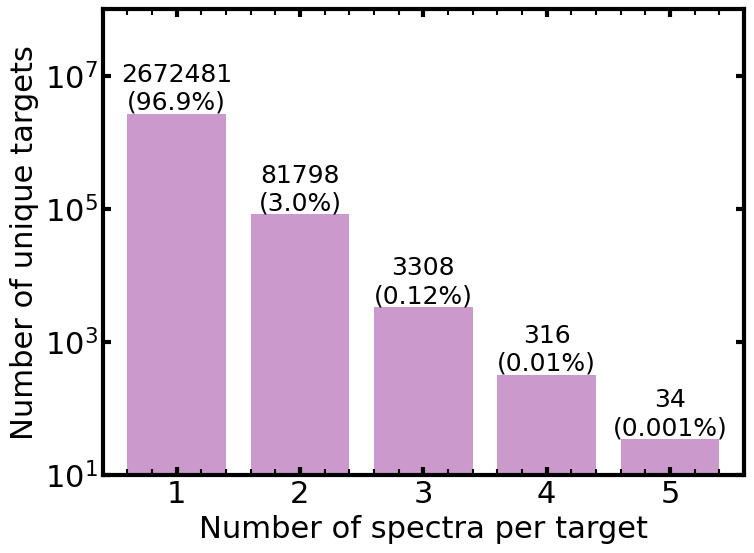

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

freq, hist = np.array(np.unique(fujidata["ZCAT_NSPEC"], return_counts=True))
hist  = ( hist / np.arange(1,np.max(freq)+1) ).astype(int)
n_tot = sum(hist)
ax.bar(freq, hist, color="purple", alpha=0.4)

ax.set_xlabel("Number of spectra per target")
ax.set_xlim(0.4,5.6)
ax.set_ylabel("Number of unique targets")
ax.set_ylim(1e1,1e8)
ax.semilogy()

round_to = [1,1,2,2,3]
pct = [f"{np.round( 100*hist[i]/n_tot, round_to[i] )}" for i in range(len(round_to))]

for i in range(len(round_to)):
    ax.text(freq[i], hist[i], f"{hist[i]}\n({pct[i]}%)", ha="center", va="bottom", fontsize=18)

plt.tight_layout()
plt.show()


#### Below we'll look more closely at the targets with five spectra


In [18]:
#-- get all targets with NSPEC=5
t_fivespec = fujidata[fujidata["ZCAT_NSPEC"]==5]

#-- unique TARGETID of each object with five spectra
targids = np.unique(t_fivespec["TARGETID"])

print("\tTARGETID\t\tSPECTYPE of all 5 spectra")
for i,tid in enumerate(targids):
    these_spec = t_fivespec[t_fivespec["TARGETID"]==tid]
    spectype   = these_spec["SPECTYPE"].data.astype(str)
    print("{0:3}\t{1}\t{2}".format(i+1, tid, spectype))


	TARGETID		SPECTYPE of all 5 spectra
  1	39627823471663007	['STAR' 'STAR' 'STAR' 'STAR' 'STAR']
  2	39627823484243615	['STAR' 'STAR' 'STAR' 'STAR' 'STAR']
  3	39627829507262519	['STAR' 'STAR' 'STAR' 'STAR' 'STAR']
  4	39627829532428134	['STAR' 'STAR' 'STAR' 'STAR' 'STAR']
  5	39627835551254147	['STAR' 'STAR' 'STAR' 'STAR' 'STAR']
  6	39627835576420141	['STAR' 'STAR' 'STAR' 'STAR' 'GALAXY']
  7	39627835576420773	['STAR' 'STAR' 'STAR' 'STAR' 'STAR']
  8	39627841582663670	['STAR' 'STAR' 'STAR' 'STAR' 'STAR']
  9	39627841586860364	['STAR' 'STAR' 'STAR' 'STAR' 'STAR']
 10	39627841620412935	['STAR' 'STAR' 'STAR' 'STAR' 'STAR']
 11	39627847626658914	['STAR' 'STAR' 'STAR' 'STAR' 'STAR']
 12	39627853662261158	['STAR' 'STAR' 'STAR' 'STAR' 'STAR']
 13	39627853662261521	['STAR' 'STAR' 'STAR' 'STAR' 'STAR']
 14	39627853679035025	['STAR' 'STAR' 'STAR' 'STAR' 'STAR']
 15	39627853679036228	['STAR' 'STAR' 'STAR' 'STAR' 'STAR']
 16	39627853687428557	['STAR' 'STAR' 'STAR' 'STAR' 'STAR']
 17	3962785971044

Most of the targets with five spectra have been flagged as stars by Redrock. One object (12 above) has four spectra flagged as a star, but the fifth classification is a galaxy. Let's look more closely at this object.

<a class="anchor" id="spectype_diff"></a>
### Targets with multiple `SPECTYPE` classifications


In [19]:
#-- get the data for all observations of this TARGETID
special_ID = 39627835576420141
these_spec = t_fivespec[ t_fivespec["TARGETID"]==special_ID]

#-- get the SURVEY, PROGRAM, SPECTYPE, and redshift values for each of the five spectra of this object
survey   = these_spec["SURVEY"].data.astype(str)
program  = these_spec["PROGRAM"].data.astype(str)
redshift = np.round(these_spec["Z"].data,5)
spectype = these_spec["SPECTYPE"].data.astype(str)

print("\tSURVEY  PROGRAM  SPECTYPE  REDSHIFT")
for i in range(5):
    print("{0:1}/5\t{1:7} {2:8} {3:8} {4:8}".format(i+1, survey[i], program[i], spectype[i], redshift[i]))


	SURVEY  PROGRAM  SPECTYPE  REDSHIFT
1/5	sv1     bright   STAR      0.00114
2/5	sv1     dark     STAR      0.00115
3/5	sv1     other    STAR      0.00114
4/5	sv3     bright   STAR       -0.002
5/5	sv3     dark     GALAXY    0.31616


The four spectra classified as `STAR` have $z\sim0$, while the redshift of the spectrum with the `GALAXY` classification is $z\sim0.316$. Let's plot several of these spectra to invesitgate the different in `SPECTYPE` classification and redshift measurement.

The `get_spec_data` function defined below is a convenience function to load the relevant data for plotting the spectrum for a given `TARGETID`, `SURVEY`, and `PROGRAM`. We will use it to load different spectra of the same object.

In [20]:
def get_spec_data(tid, survey=None, program=None):
    #-- the index of the specific target can be uniquely determined with the combination of TARGETID, SURVEY, and PROGRAM
    idx = np.where( (fujidata["TARGETID"]==tid) & (fujidata["SURVEY"]==survey) & (fujidata["PROGRAM"]==program) )[0][0]

    #-- healpix values are integers but are converted here into a string for easier access to the file path
    hpx = fujidata["HEALPIX"].astype(str)

    if "sv" in survey:
        specprod = "fuji"

    specprod_dir = f"/global/cfs/cdirs/desi/spectro/redux/{specprod}"
    target_dir   = f"{specprod_dir}/healpix/{survey}/{program}/{hpx[idx][:-2]}/{hpx[idx]}"
    coadd_fname  = f"coadd-{survey}-{program}-{hpx[idx]}.fits"

    #-- read in the spectra with desispec
    coadd_obj  = desispec.io.read_spectra(f"{target_dir}/{coadd_fname}")
    coadd_tgts = coadd_obj.target_ids().data

    #-- select the spectrum of  targetid
    row = ( coadd_tgts==fujidata["TARGETID"][idx] )
    coadd_spec = coadd_obj[row]

    return coadd_spec


In [21]:
#-- get the third, fourth, and fifth spectra for this object 

tid = special_ID #-- TARGETID

#-- 3/5 above; SPECTYPE = STAR
sv1_other_star = get_spec_data(tid, survey="sv1", program="other")

#-- 4/5 above; SPECTYPE = STAR
sv3_bright_star = get_spec_data(tid, survey="sv3", program="bright")

#-- 5/5 above; SPECTYPE = GALAXY
sv3_dark_gal = get_spec_data(tid, survey="sv3", program="dark")


INFO:spectra.py:291:read_spectra: iotime 1.021 sec to read coadd-sv1-other-27256.fits at 2023-05-17T13:13:35.230855
INFO:spectra.py:291:read_spectra: iotime 2.050 sec to read coadd-sv3-bright-27256.fits at 2023-05-17T13:13:39.178798
INFO:spectra.py:291:read_spectra: iotime 2.615 sec to read coadd-sv3-dark-27256.fits at 2023-05-17T13:13:44.691147


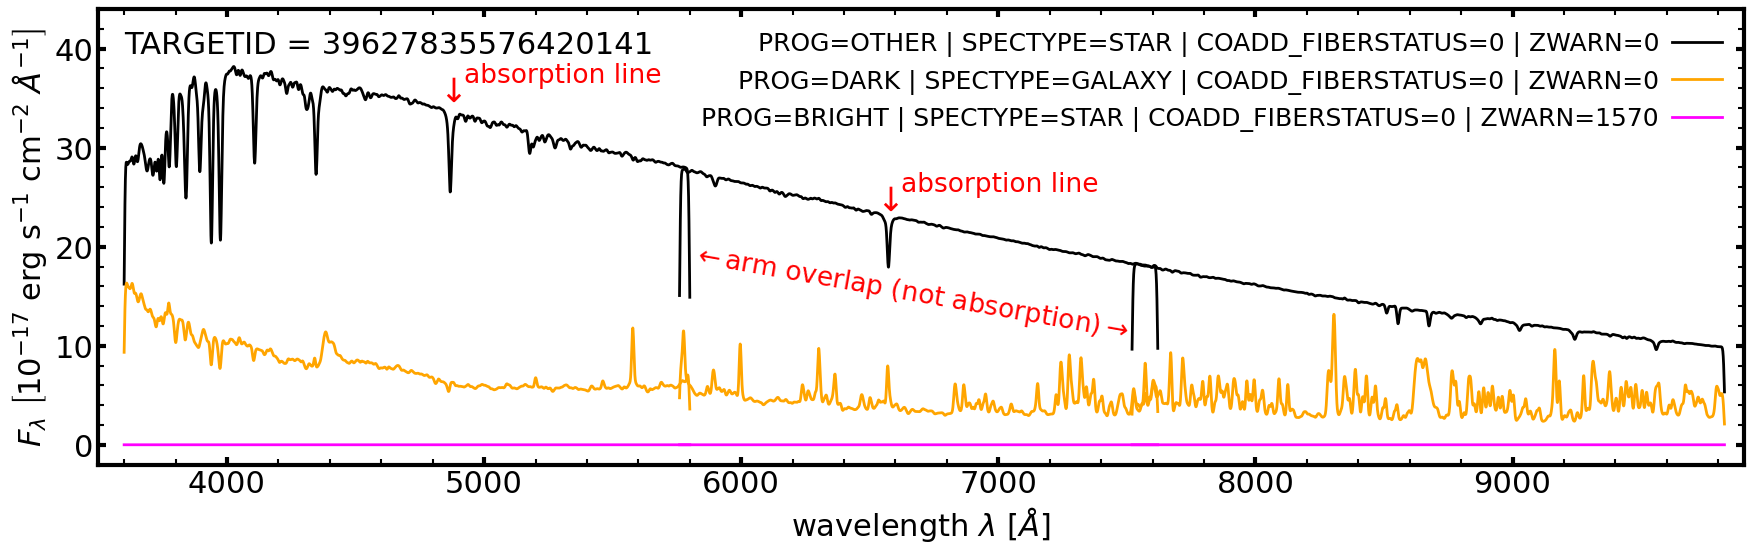

In [22]:
#-- plot the spectra

fig, ax = plt.subplots(1, 1, figsize=(18,6))

ax.set_xlim(3500, 9900)
ax.set_xlabel(r"wavelength $\lambda\ \left[ \AA \right]$")
ax.set_ylim(-2, 44)
ax.set_ylabel(r"$F_{\lambda}\ \left[ 10^{-17}\ {\rm erg\ s}^{-1}\ {\rm cm}^{-2}\ \AA^{-1} \right]$")

spectra = ( sv1_other_star, sv3_dark_gal, sv3_bright_star )
zwarn   = (0,0,1570)
coaddfs = (0,0,0)
for PROG,ST,spec,color,zw,cfs in zip( ("OTHER","DARK","BRIGHT"), ("STAR","GALAXY","STAR"), spectra, ("k","orange","magenta"), zwarn, coaddfs ):
    for band in ("b","r","z"):
        label = f"PROG={PROG} | SPECTYPE={ST} | COADD_FIBERSTATUS={cfs} | ZWARN={zw}" if band=="b" else ""
        ax.plot(spec.wave[band], convolve(spec.flux[band][0], Gaussian1DKernel(5)), label=label, color=color, lw=2)

ax.text(3600, 39, f"TARGETID = {tid}", ha="left", va="bottom")
ax.legend(markerfirst=False, fontsize=18, handletextpad=0.5, frameon=False)

#-- annotations
ax.text(5800, 10, r"$\leftarrow$" + "arm overlap (not absorption)" + r"$\rightarrow$", ha="left", va="bottom", fontsize=19, color="red", rotation=350)
ax.text(4800, 34, r"$\downarrow$", ha="left", va="bottom", fontsize=24, color="red")
ax.text(6500, 23, r"$\downarrow$", ha="left", va="bottom", fontsize=24, color="red")
ax.text(4920, 36, "absorption line", ha="left", va="bottom", fontsize=19, color="red")
ax.text(6620, 25, "absorption line", ha="left", va="bottom", fontsize=19, color="red")

plt.tight_layout()

The SV1 dark time spectrum (black line) is clearly a stellar spectrum and correctly classified by Redrock, while the shape of the SV3 "other" program spectrum (orange line) is somewhat ambiguous. It is not surpising that this spectrum was misclassified as a galaxy. The SV3 bright time spectrum (magenta line) obviously has no flux data, and it is not immediately clear why it was classified as a stellar spectrum. Below we'll look at additional columns for these spectra.


In [23]:
#-- show all data columns for the five spectra for this target

t_fivespec[ t_fivespec["TARGETID"]==tid ].show_in_notebook()


idx,TARGETID,SURVEY,PROGRAM,HEALPIX,SPGRPVAL,Z,ZERR,ZWARN,CHI2,COEFF,NPIXELS,SPECTYPE,SUBTYPE,NCOEFF,DELTACHI2,COADD_FIBERSTATUS,TARGET_RA,TARGET_DEC,PMRA,PMDEC,REF_EPOCH,FA_TARGET,FA_TYPE,OBJTYPE,SUBPRIORITY,OBSCONDITIONS,RELEASE,BRICKNAME,BRICKID,BRICK_OBJID,MORPHTYPE,EBV,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_IVAR_W1,FLUX_IVAR_W2,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,MASKBITS,SERSIC,SHAPE_R,SHAPE_E1,SHAPE_E2,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_RP_MEAN_MAG,PARALLAX,PHOTSYS,PRIORITY_INIT,NUMOBS_INIT,CMX_TARGET,DESI_TARGET,BGS_TARGET,MWS_TARGET,SCND_TARGET,SV1_DESI_TARGET,SV1_BGS_TARGET,SV1_MWS_TARGET,SV1_SCND_TARGET,SV2_DESI_TARGET,SV2_BGS_TARGET,SV2_MWS_TARGET,SV2_SCND_TARGET,SV3_DESI_TARGET,SV3_BGS_TARGET,SV3_MWS_TARGET,SV3_SCND_TARGET,PLATE_RA,PLATE_DEC,COADD_NUMEXP,COADD_EXPTIME,COADD_NUMNIGHT,COADD_NUMTILE,MEAN_DELTA_X,RMS_DELTA_X,MEAN_DELTA_Y,RMS_DELTA_Y,MEAN_FIBER_RA,STD_FIBER_RA,MEAN_FIBER_DEC,STD_FIBER_DEC,MEAN_PSF_TO_FIBER_SPECFLUX,TSNR2_GPBDARK_B,TSNR2_ELG_B,TSNR2_GPBBRIGHT_B,TSNR2_LYA_B,TSNR2_BGS_B,TSNR2_GPBBACKUP_B,TSNR2_QSO_B,TSNR2_LRG_B,TSNR2_GPBDARK_R,TSNR2_ELG_R,TSNR2_GPBBRIGHT_R,TSNR2_LYA_R,TSNR2_BGS_R,TSNR2_GPBBACKUP_R,TSNR2_QSO_R,TSNR2_LRG_R,TSNR2_GPBDARK_Z,TSNR2_ELG_Z,TSNR2_GPBBRIGHT_Z,TSNR2_LYA_Z,TSNR2_BGS_Z,TSNR2_GPBBACKUP_Z,TSNR2_QSO_Z,TSNR2_LRG_Z,TSNR2_GPBDARK,TSNR2_ELG,TSNR2_GPBBRIGHT,TSNR2_LYA,TSNR2_BGS,TSNR2_GPBBACKUP,TSNR2_QSO,TSNR2_LRG,SV_NSPEC,SV_PRIMARY,ZCAT_NSPEC,ZCAT_PRIMARY
0,39627835576420141,sv1,bright,27256,27256,0.0011417368469184594,4.095495353706594e-06,0,8838.941289415088,6392.919297435823 .. 0.0,7927,STAR,F,5,13079.627106254098,0,150.8397829188431,2.0302946855385895,-7.495269,-3.4361079,2021.0883,2305843052163366912,3,TGT,0.27043005206214,7,9010,1508p020,342491,1837,PSF,0.01936283,68.24761,90.43967,96.551445,25.577448,13.073274,116.89038,54.455704,29.06246,2.3624856,0.5857435,53.075703,70.33431,75.0874,53.075706,70.33432,75.08743,0,0.0,0.0,0.0,0.0,3836010080046851072,G2,17.667353,17.877104,17.243767,0.68027276,S,1100,1,0,0,0,0,0,2305843052163366912,0,33,0,0,0,0,0,0,0,0,0,150.8397829188431,2.0302946855385895,7,6330.382,3,1,0.0035832778,0.0113409795,0.003084996,0.004722496,150.83978778997462,0.121175125,2.0302853254507016,0.053052835,0.789,55.40914,0.03674524,11.160031,28.527657,214.3489,97.019325,0.981001,0.37086573,3823.9243,8.938565,758.6612,0.018770928,859.0104,6279.485,2.623373,12.584695,7.656398e-06,44.699924,1.5386753e-06,0.0,1872.1166,1.3271912e-05,8.7765,19.009697,3879.3335,53.675236,769.8212,28.546427,2945.4758,6376.5044,12.380874,31.965258,5,False,5,False
1,39627835576420141,sv1,dark,27256,27256,0.0011481472801551324,8.767969364245273e-07,0,27157.4397228281,6342.946596010624 .. 0.0,7928,STAR,F,5,389563.493802269,0,150.83978316486633,2.030294866360465,-7.495269,-3.4361079,2020.9487,2305843052163366912,3,TGT,0.3132573305466272,7,9010,,342491,1837,PSF,0.01936283,68.24761,90.43967,96.551445,25.577448,13.073274,116.89038,54.455704,29.06246,2.3624856,0.5857435,53.075703,70.33431,75.0874,53.075706,70.33432,75.08743,0,0.0,0.0,0.0,0.0,3836010080046851072,G2,17.667353,17.877104,17.243767,0.68027276,S,1100,1,0,0,0,0,0,2305843052163366912,0,33,0,0,0,0,0,0,0,0,0,150.83978316486633,2.030294866360465,31,27455.465,6,2,-0.0006129032,0.008574155,0.0017096774,0.008232509,150.83978851531282,0.12263742,2.0303026265447923,0.117334686,0.789,3888.989,3.0252707,722.07825,3122.5254,14667.599,5096.7627,82.62242,23.044636,230674.23,467.24292,41044.355,0.91731435,48259.79,261390.17,151.73328,693.4119,0.00030713485,1587.981,5.7122452e-05,0.0,74759.35,0.00040694026,340.0303,755.2864,234563.22,2058.249,41766.434,3123.4426,137686.73,266486.94,574.386,1471.7429,5,False,5,False
2,39627835576420141,sv1,other,27256,27256,0.0011435554212226827,6.569065910730206e-07,0,50204.96818820806,6452.8813485135 .. 0.0,7928,STAR,F,5,628192.3800933082,0,150.83978256299054,2.0302946250072194,-7.495269,-3.4361079,2

Looking at all the columns for these five spectra, we can see that all five have `COADD_FIBERSTATUS=0` (i.e., no bad fiber warning). However, the spectrum with no flux (4/5) has `ZWARN=1570`, while the other (good) spectra all have `ZWARN=0`. Scroll to the final column (`ZCAT_PRIMARY`) and we'll see that the third spectra (black line in the above plot) is the primary spectrum for this target.

<a class="anchor" id="bright_dark"></a>
### `BRIGHT` versus `DARK` program spectra of the same target

Now we'll look more closely at the `SURVEY`, `PROGRAM`, and redshift values of 34 targets with five spectra.

In [24]:
for tid in targids[:34]:
    these_spec = t_fivespec[t_fivespec["TARGETID"]==tid]
    survey   = these_spec["SURVEY"].data.astype(str)
    program  = these_spec["PROGRAM"].data.astype(str)
    redshift = these_spec["Z"].data
    spectype = these_spec["SPECTYPE"].data.astype(str)

    print(f"TARGETID = {tid}")
    print("    Survey  \t{0}\t{1}\t{2}\t{3}\t{4}".format(*survey))
    print("    Program \t{0}\t{1}\t{2}\t{3}\t{4}".format(*program))
    print("    Redshift\t{0:.4f}\t{1:.4f}\t{2:.4f}\t{3:.4f}\t{4:.4f}".format(*redshift))
    print("    Spectype \t{0}\t{1}\t{2}\t{3}\t{4}\n".format(*spectype))

TARGETID = 39627823471663007
    Survey  	sv1	sv1	sv1	sv3	sv3
    Program 	bright	dark	other	bright	dark
    Redshift	0.0010	-0.0020	0.0010	0.0010	0.0010
    Spectype 	STAR	STAR	STAR	STAR	STAR

TARGETID = 39627823484243615
    Survey  	sv1	sv1	sv1	sv3	sv3
    Program 	bright	dark	other	bright	dark
    Redshift	-0.0020	0.0004	0.0004	0.0004	0.0003
    Spectype 	STAR	STAR	STAR	STAR	STAR

TARGETID = 39627829507262519
    Survey  	sv1	sv1	sv1	sv3	sv3
    Program 	bright	dark	other	bright	dark
    Redshift	0.0008	0.0008	0.0008	0.0008	0.0008
    Spectype 	STAR	STAR	STAR	STAR	STAR

TARGETID = 39627829532428134
    Survey  	sv1	sv1	sv1	sv3	sv3
    Program 	bright	dark	other	bright	dark
    Redshift	0.0002	0.0003	0.0003	0.0003	0.0003
    Spectype 	STAR	STAR	STAR	STAR	STAR

TARGETID = 39627835551254147
    Survey  	sv1	sv1	sv1	sv3	sv3
    Program 	bright	dark	other	bright	dark
    Redshift	-0.0020	0.0003	0.0003	0.0003	0.0003
    Spectype 	STAR	STAR	STAR	STAR	STAR

TARGETID = 39627835576420141
   

Each of these targets was observed three times during SV1 and twice during SV3 (once each during the bright and dark programs). 

Below we compare the dark and bright time spectra of this object from SV3. The top panel shows the smoothed bright time spectrum in magenta against the smoothed dark time spectrum in black. The middle and bottom panels show the bright and dark time spectra, respectively, smoothed in black, as well as the flux from each arm (*B*, *R*, and *Z*) shown in blue, green, and red. As expected, the bright time spectrum is clearly nosier than the dark time. 

In [25]:
#-- get two spectra for this object (first of the 34 galaxies with five spectra)

tid = targids[0] #-- TARGETID 

#-- get the DARK TIME spectrum
spec_dark = get_spec_data(tid, survey="sv3", program="dark")

#-- get the BRIGHT TIME spectrum
spec_bright = get_spec_data(tid, survey="sv3", program="bright")


INFO:spectra.py:291:read_spectra: iotime 2.483 sec to read coadd-sv3-dark-27247.fits at 2023-05-17T13:14:16.216173
INFO:spectra.py:291:read_spectra: iotime 2.052 sec to read coadd-sv3-bright-27247.fits at 2023-05-17T13:14:21.355591


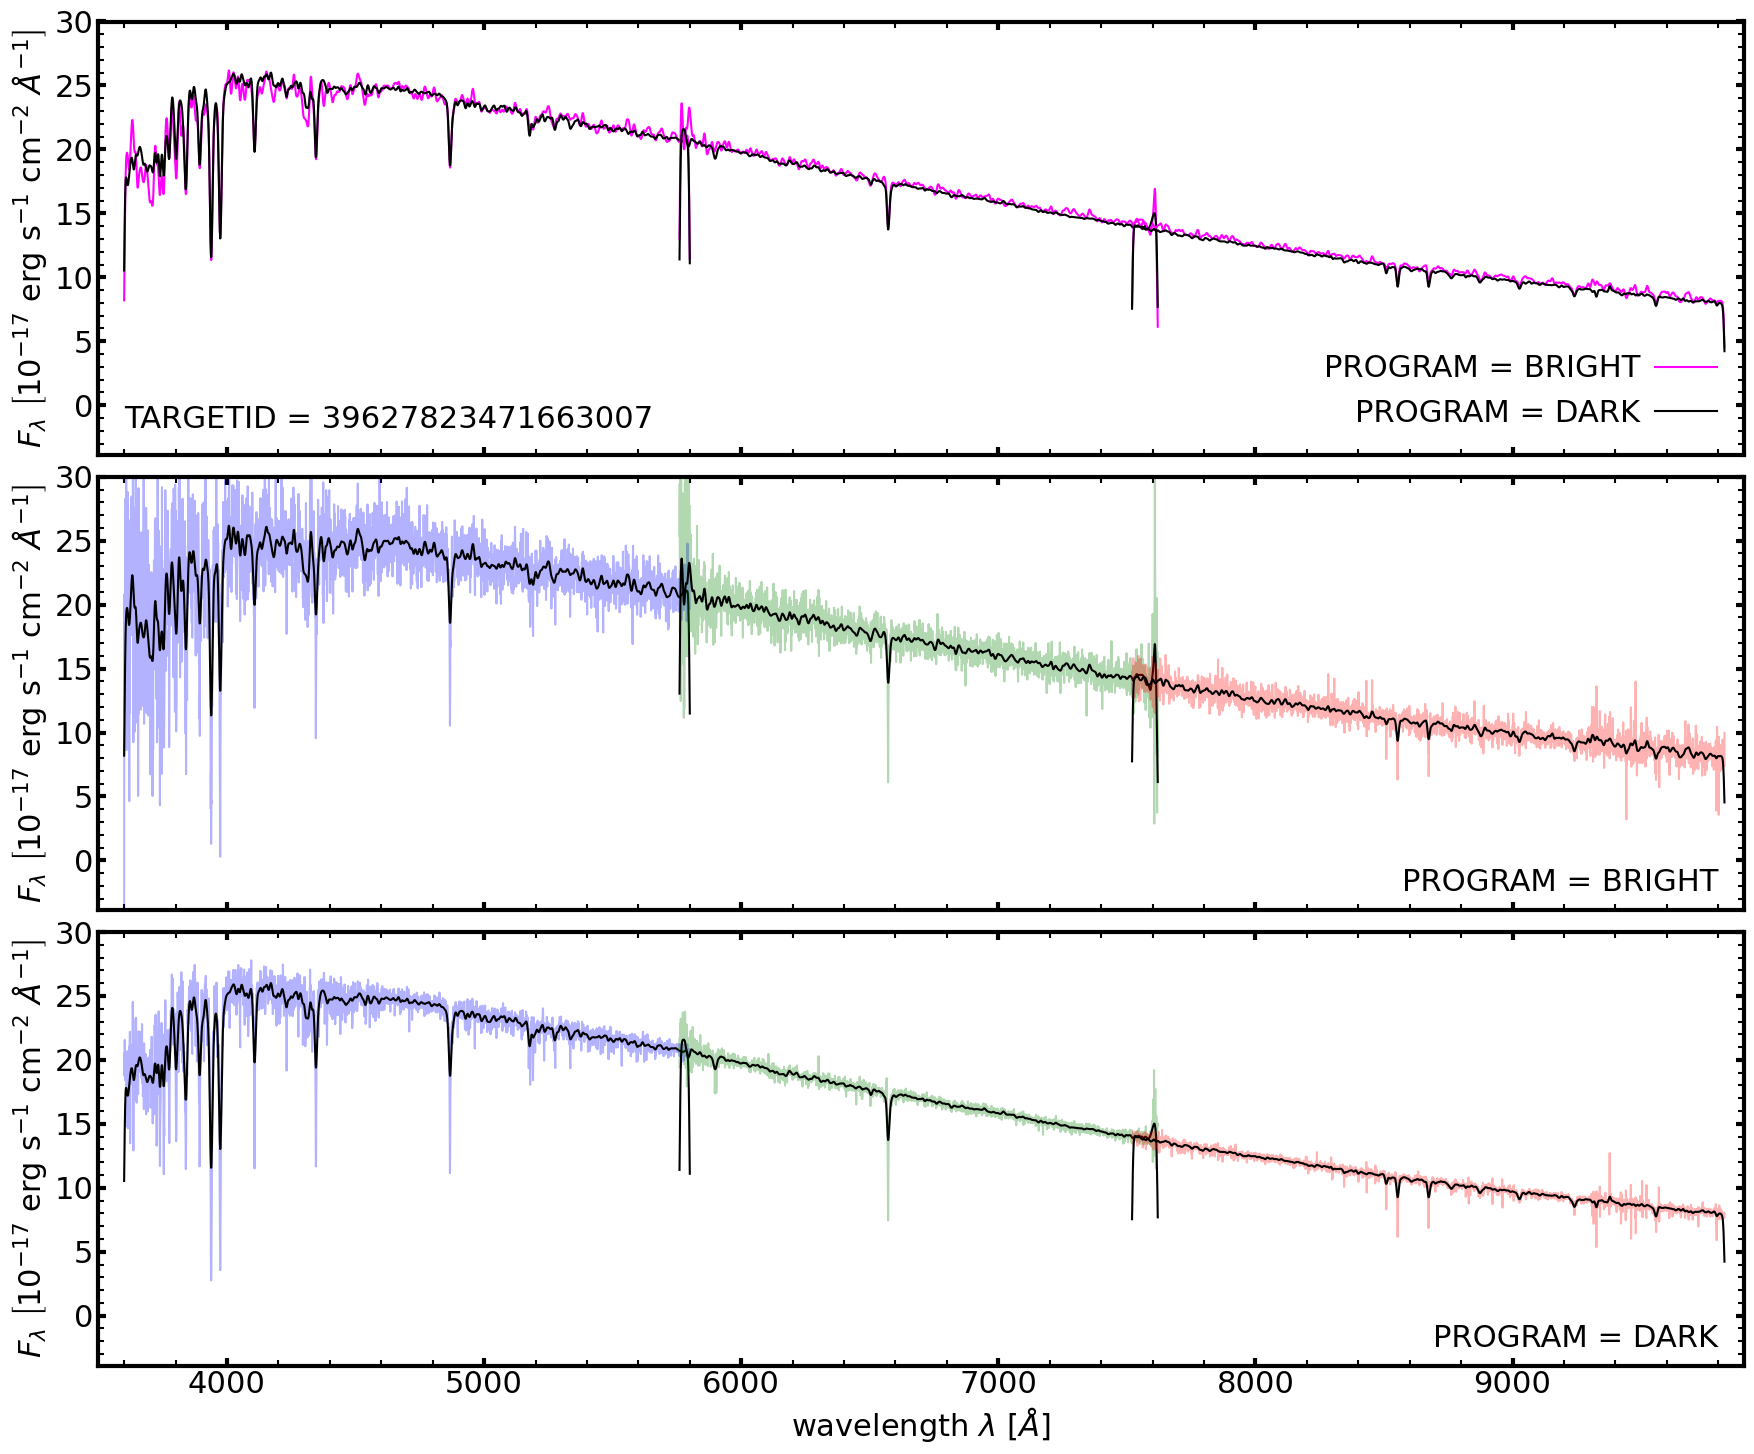

In [36]:
#-- plot the spectra

fig, axes = plt.subplots(3, 1, figsize=(18,15), sharex=True, sharey=True)

for ax in axes:
    ax.set_xlim(3500, 9900)
    ax.set_ylim(-3.9, 30)  #-- change depending on specific spectrum
    ax.set_ylabel(r"$F_{\lambda}\ \left[ 10^{-17}\ {\rm erg\ s}^{-1}\ {\rm cm}^{-2}\ \AA^{-1} \right]$")

axes[-1].set_xlabel(r"wavelength $\lambda\ \left[ \AA \right]$")

#-- plot the BRIGHT TIME and DARK TIME spectra (both smoothed) on the same axis
for band in ("b","r","z"):
    if band=="z":
        label_bright = "PROGRAM = BRIGHT"
        label_dark   = "PROGRAM = DARK"
    else:
        label_bright = label_dark = ""
    axes[0].plot(spec_bright.wave[band], convolve(spec_bright.flux[band][0], Gaussian1DKernel(5)), color="magenta", label=label_bright)
    axes[0].plot(spec_dark.wave[band], convolve(spec_dark.flux[band][0], Gaussian1DKernel(5)), color="k", label=label_dark)
axes[0].legend(markerfirst=False, loc=4, handletextpad=0.5, frameon=False)
axes[0].text(3600, 0, f"TARGETID = {tid}", ha="left", va="top")

#-- plot the BRIGHT TIME and DARK TIME spectra at full resolution on separate axes
for ax,coadd_spec,prog in zip(axes[1:],(spec_bright,spec_dark),("BRIGHT","DARK")):
    ax.text(9800, 2, f"\nPROGRAM = {prog.upper()}", ha="right", va="top")
    for band,color in zip(("b","r","z"),("b","g","r")):
        #-- plot the spectrum from each arm (B,R,Z) in blue, green, red
        ax.plot(coadd_spec.wave[band], coadd_spec.flux[band][0], color=color, alpha=0.3)
        #-- add smoothed spectrum in black for all the three arms
        ax.plot(coadd_spec.wave[band], convolve(coadd_spec.flux[band][0], Gaussian1DKernel(5)), color="k")
        
plt.tight_layout()
plt.subplots_adjust(hspace=0.05)